In [1]:
import inspect
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")


In [19]:
def wrangle(filepath):

    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Drop a  all column
    df = df.drop(columns=["unix",'symbol','low','open','high','Volume BTC','Volume USD'])


    # Convert date column to datetime format
    df["date"] = pd.to_datetime(df["date"])

    # Set date column as index
    df.set_index("date", inplace=True)

    # Create "return" column
    df['return']=df['close'].pct_change() * 100

    # Drob NaN
    y = df['return'].dropna()

    return y

In [20]:
y=wrangle(r'C:\Users\Nassoh\Desktop\DataSienceMyProject\BTC Price\Data\BTCUSD_day.csv')
y.shape
y

date
2023-04-24   -0.032702
2023-04-23    0.305321
2023-04-22    0.800841
2023-04-21   -2.023942
2023-04-20    3.610479
                ...   
2014-12-02    0.684950
2014-12-01   -0.226763
2014-11-30   -1.334602
2014-11-29    0.905341
2014-11-28   -0.116798
Name: return, Length: 3070, dtype: float64

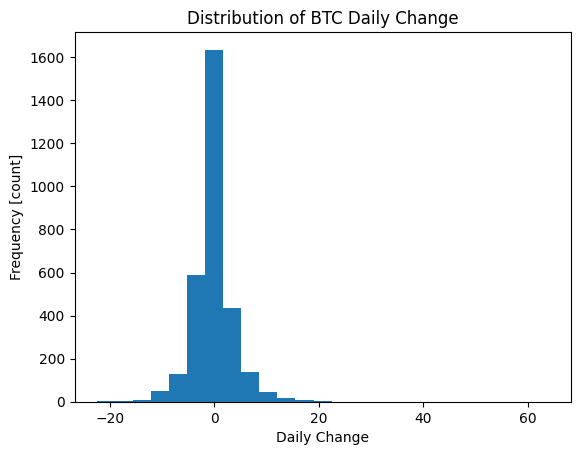

In [21]:
# Create histogram of `BTC`, 25 bins
plt.hist(y,bins=25)

# Add axis labels
plt.xlabel('Daily Change')
plt.ylabel('Frequency [count]')


# Add title
plt.title('Distribution of BTC Daily Change')
plt.show()

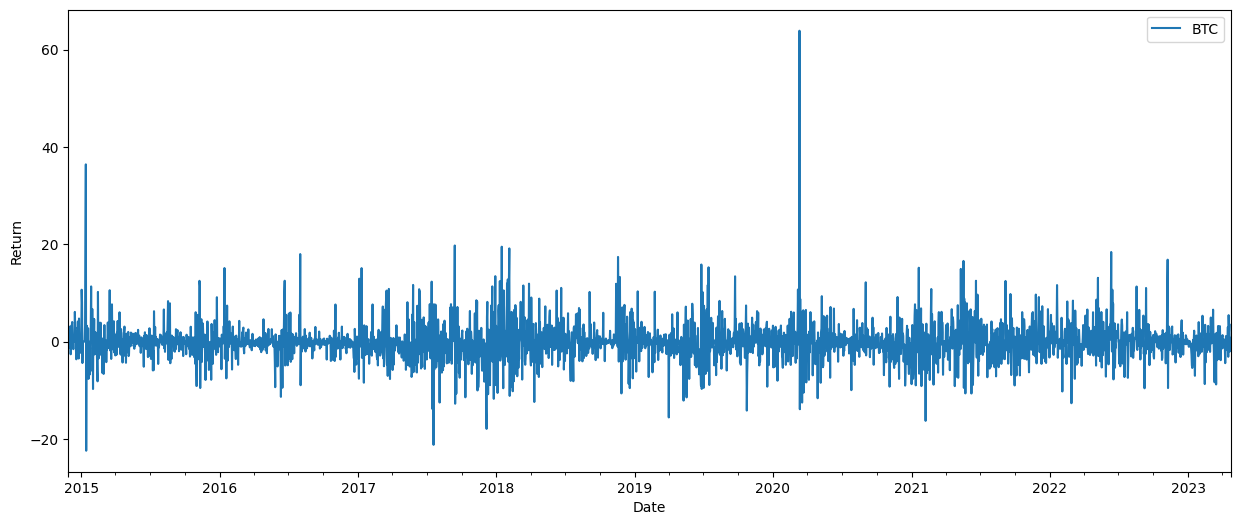

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `BTC`
y.plot(ax=ax, label="BTC")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend()
plt.show()

# Volatility

In [26]:
import numpy as np


BTC_volatility = y.std()
BTC_annual_volatility = BTC_volatility * np.sqrt(252)
BTC_rolling_50d_volatility = y.rolling(window=50).std().dropna()
print("BTC Daily Volatility:", BTC_volatility)
print("BTC_annual_volatility:", BTC_annual_volatility)
print("rolling_50d_volatility shape:", BTC_rolling_50d_volatility.shape)
BTC_rolling_50d_volatility.head()

BTC Daily Volatility: 4.008708247417616
BTC_annual_volatility: 63.636270607683564
rolling_50d_volatility shape: (3021,)


date
2023-03-06    3.025396
2023-03-05    3.025731
2023-03-04    3.024199
2023-03-03    3.020111
2023-03-02    3.103066
Name: return, dtype: float64

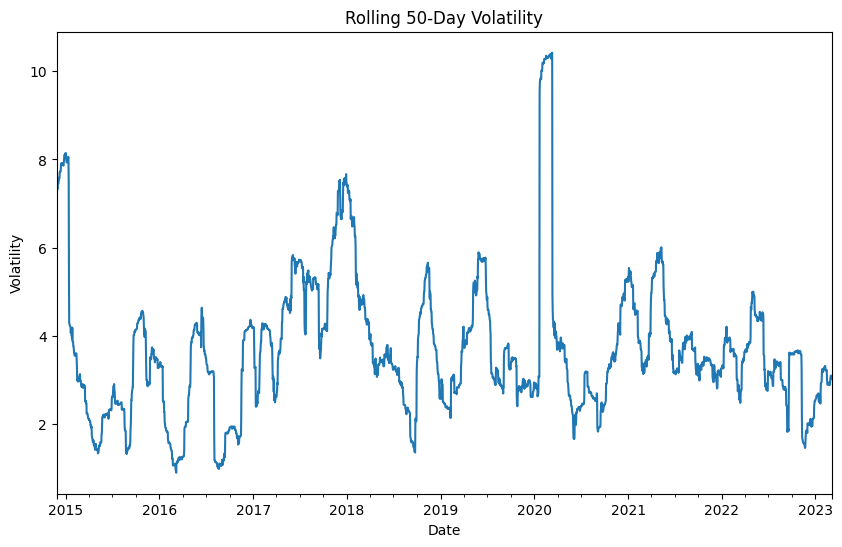

In [28]:
# assuming rolling_50d_volatility is a pandas Series object
BTC_rolling_50d_volatility.plot(figsize=(10, 6))
plt.title('Rolling 50-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

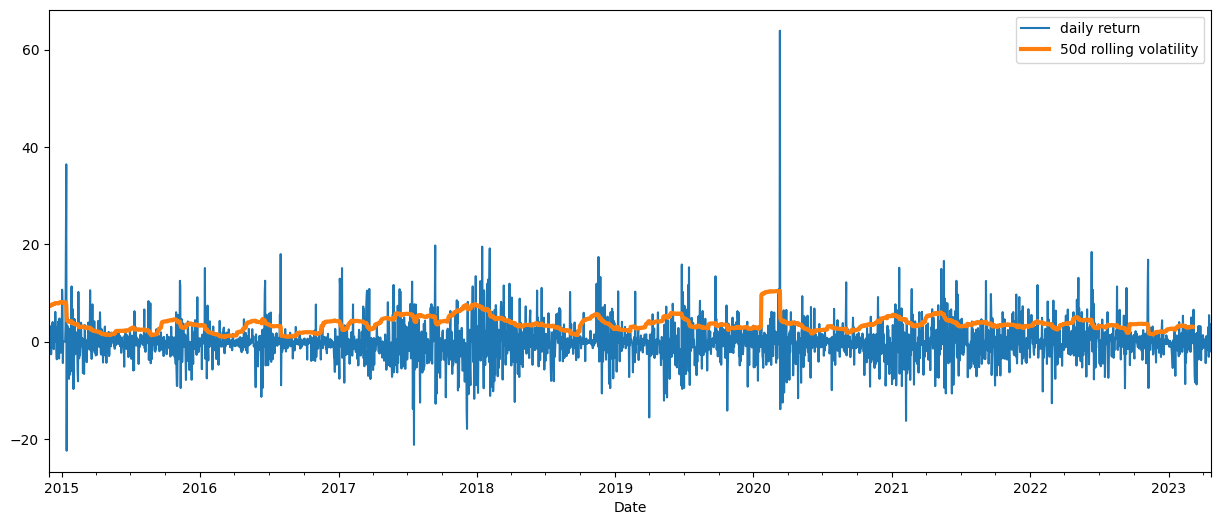

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja`
y.plot(ax=ax,label='daily return')

# Plot `ambuja_rolling_50d_volatility`
BTC_rolling_50d_volatility.plot(ax=ax,label='50d rolling volatility',linewidth=3)

# Add x-axis label
plt.xlabel('Date')

# Add legend
plt.legend()
plt.show()

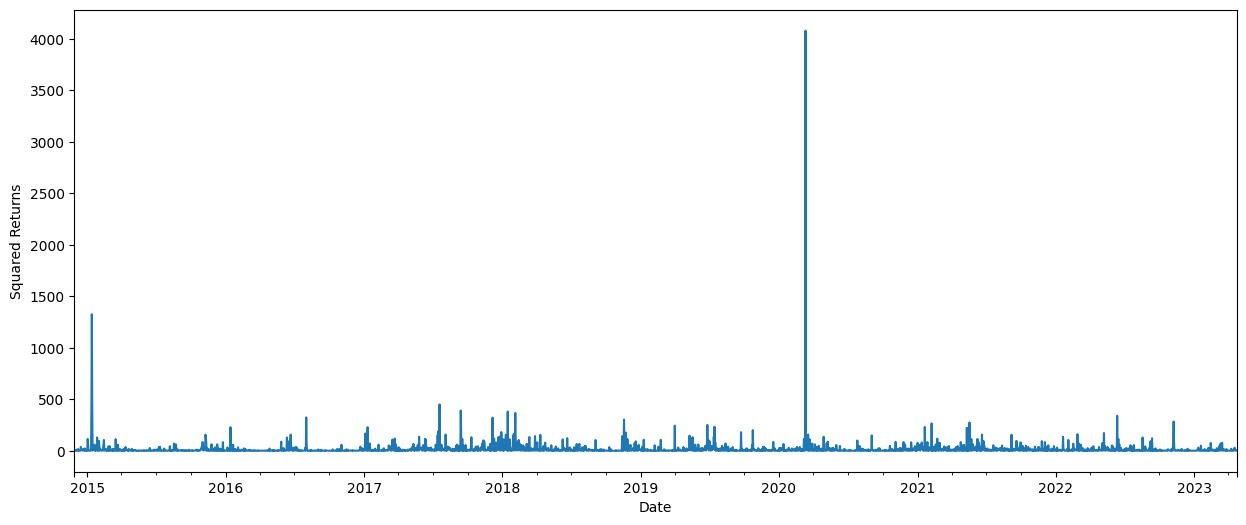

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y**2).plot(ax=ax)
# Add axis labels
plt.xlabel('Date')
plt.ylabel('Squared Returns')
plt.show()


# Acf and Pacf

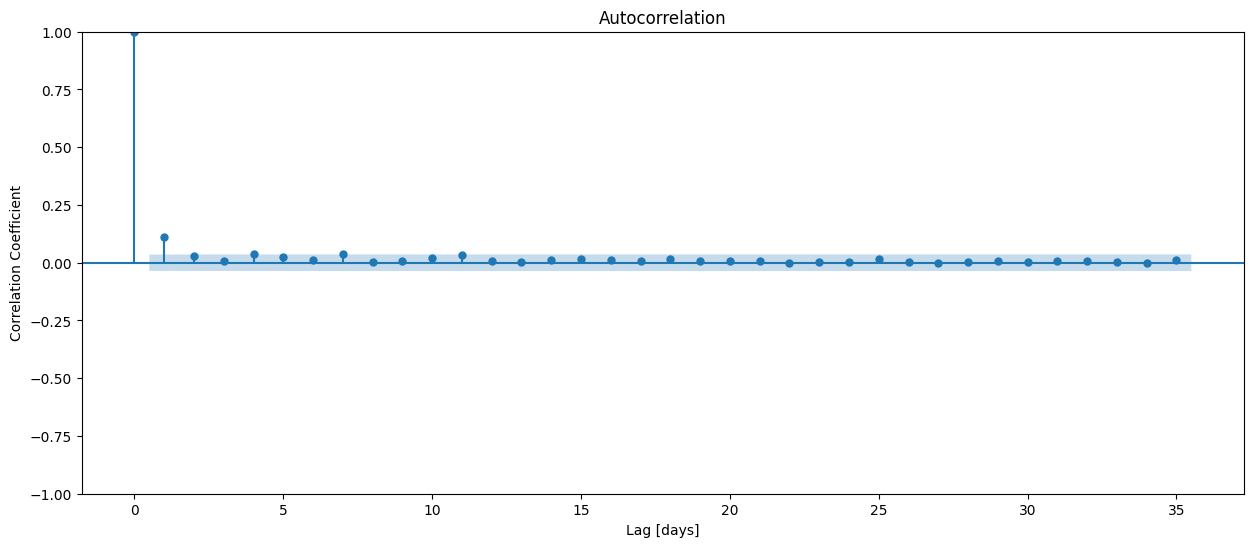

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y**2,ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()


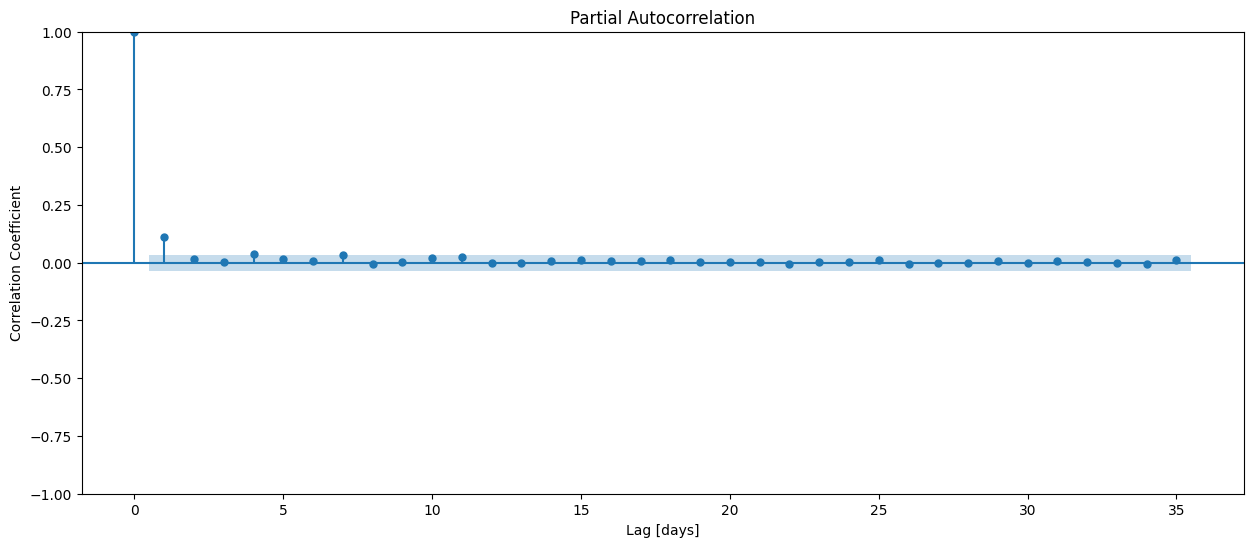

In [43]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y**2,ax=ax)

# Add axis labels
plt.xlabel('Lag [days]')
plt.ylabel('Correlation Coefficient')
plt.show()


# Split

In [44]:
cutoff_test = int(len(y)*0.8)
y_train = y.iloc[:cutoff_test]

print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)
y_train.tail()

y_train type: <class 'pandas.core.series.Series'>
y_train shape: (2456,)


date
2016-08-07    0.532691
2016-08-06   -0.644617
2016-08-05   -2.061891
2016-08-04   -0.194229
2016-08-03   -1.718446
Name: return, dtype: float64

# Build Model

In [45]:
from arch import arch_model

# Build and train model
model = arch_model(
    y_train,
    p=1,
    q=1,
    rescale=False
).fit()
print("model type:", type(model))

# Show model summary
model.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 53014.607573383095
Iteration:      2,   Func. Count:     14,   Neg. LLF: 11536.621926698124
Iteration:      3,   Func. Count:     21,   Neg. LLF: 6789.782564330866
Iteration:      4,   Func. Count:     27,   Neg. LLF: 6681.723172317058
Iteration:      5,   Func. Count:     32,   Neg. LLF: 6737.05644512545
Iteration:      6,   Func. Count:     38,   Neg. LLF: 7156.651544767778
Iteration:      7,   Func. Count:     45,   Neg. LLF: 6699.0258698114585
Iteration:      8,   Func. Count:     51,   Neg. LLF: 6678.369130165858
Iteration:      9,   Func. Count:     56,   Neg. LLF: 6678.347277490149
Iteration:     10,   Func. Count:     61,   Neg. LLF: 6678.3466749128775
Iteration:     11,   Func. Count:     66,   Neg. LLF: 6678.346673154145
Iteration:     12,   Func. Count:     70,   Neg. LLF: 6678.346673154469
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6678.346673154145
            Iterations: 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6678.35
Distribution:                  Normal   AIC:                           13364.7
Method:            Maximum Likelihood   BIC:                           13387.9
                                        No. Observations:                 2456
Date:                Sat, May 13 2023   Df Residuals:                     2455
Time:                        18:43:40   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1231  6.570e-02     -1.874  6.094e-02 [ -0.252,5.652e-03]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.7942      0.241      3.289  1.005e-03   [  0.321,  1.267]
alpha[1]       0.1991  5.087e-02      3.914  9.067e-05 [9.942e-02,  0.299]
beta[1]        0.7781  3.839e-02     20.266  2.568e-91   [  0.703,  0.853]
==========================================================================

Covariance estimator: robust
"""

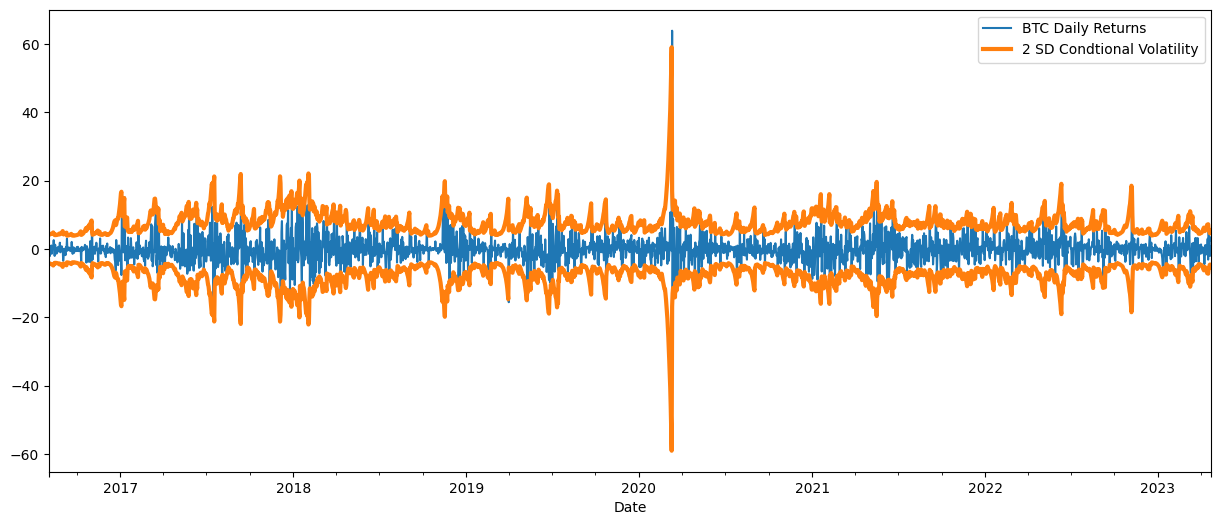

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_ambuja_train`
y_train.plot(ax=ax,label='BTC Daily Returns')

# Plot conditional volatility * 2
(2*model.conditional_volatility).plot(
    ax=ax,color='C1',label='2 SD Condtional Volatility',linewidth=3
)

# Plot conditional volatility * -2
(-2*model.conditional_volatility.rename('')).plot(
    ax=ax,color='C1',linewidth=3
)
# Add axis labels
plt.xlabel('Date')


# Add legend
plt.legend()
plt.show()

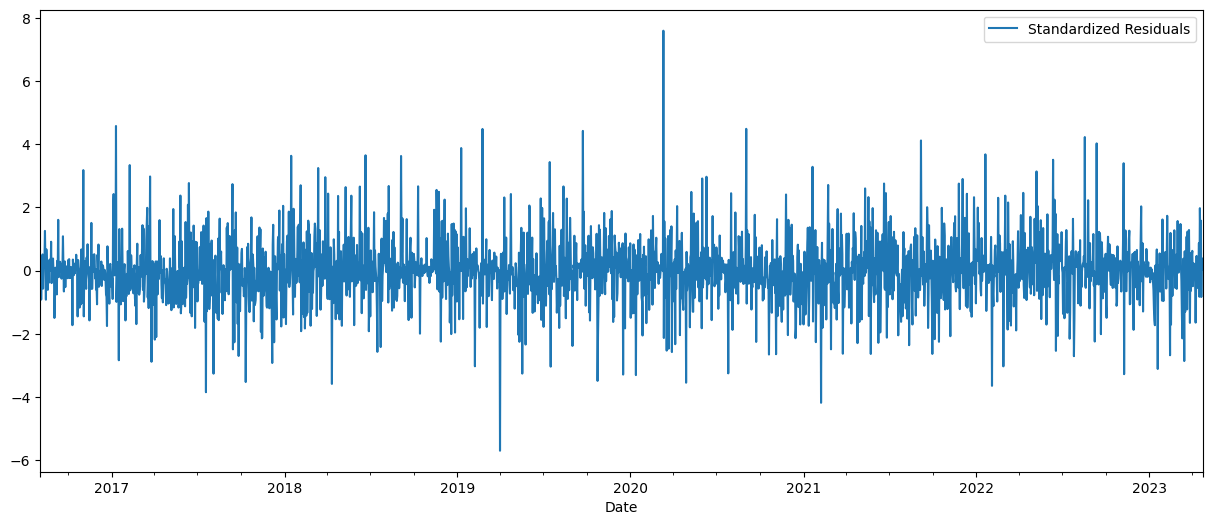

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax,label='Standardized Residuals')

# Add axis labels
plt.xlabel('Date')


# Add legend
plt.legend()
plt.show()

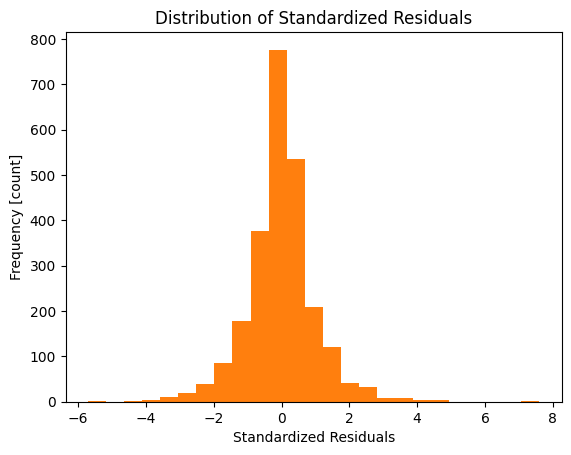

In [53]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid,bins=25)

# Add axis labels
plt.xlabel('Standardized Residuals')
plt.ylabel('Frequency [count]')

# Add title
plt.title('Distribution of Standardized Residuals')
plt.show()

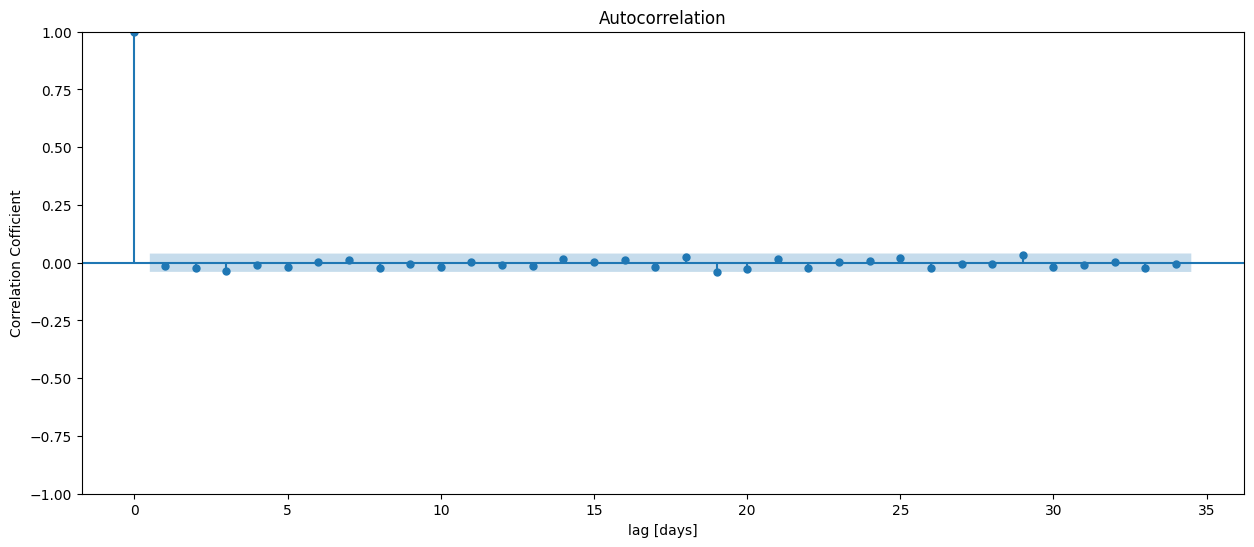

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel('lag [days]')
plt.ylabel('Correlation Cofficient')
plt.show()


# Evaluate

In [57]:
one_day_forecast = model.forecast(horizon=1,reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2016-08-03,4.965179


In [59]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1,reindex=False).variance.iloc[0,0]**0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (614,)


date
2016-08-02    2.228268
2016-08-01    4.516168
2016-07-31    9.317464
2016-07-30    8.233430
2016-07-29    7.699429
dtype: float64

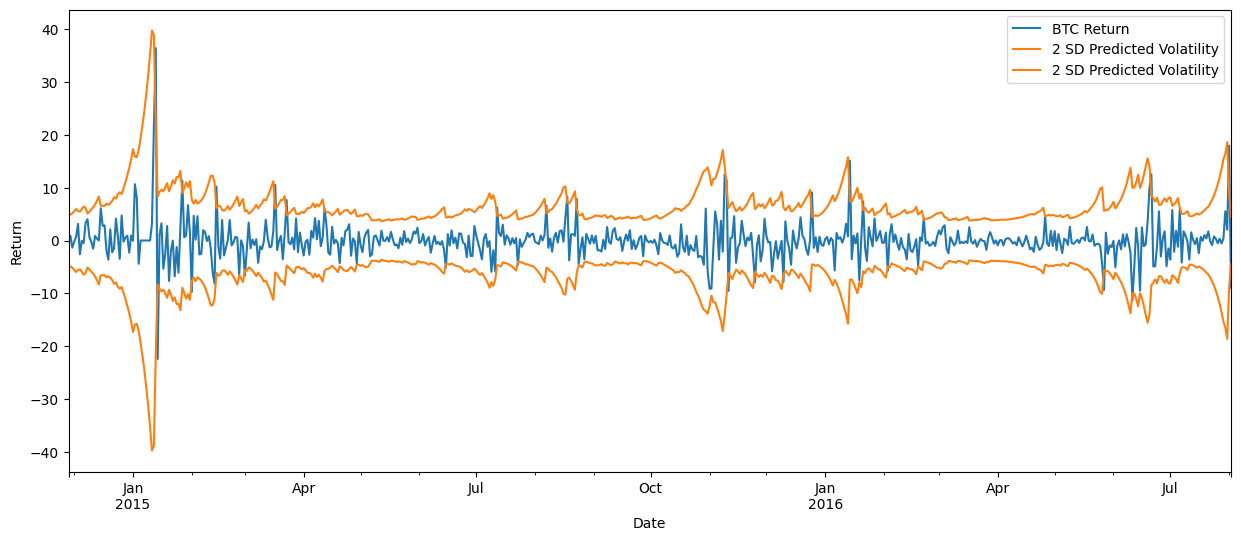

In [62]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y.tail(test_size).plot(ax=ax, label="BTC Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1",label='2 SD Predicted Volatility')

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();
plt.show()

In [63]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start = prediction.index[0]+pd.DateOffset(days=1)

# Create date range
prediction_dates =pd.bdate_range(start=start,periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:]

                 h.1       h.2       h.3       h.4      h.5
date                                                       
2014-11-29  2.361827  2.482234  2.596132  2.704353  2.80756
prediction_index type: <class 'list'>
prediction_index len: 5


['2014-12-01T00:00:00',
 '2014-12-02T00:00:00',
 '2014-12-03T00:00:00',
 '2014-12-04T00:00:00',
 '2014-12-05T00:00:00']

In [64]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start = prediction.index[0]+pd.DateOffset(days=1)

    # Create date range
    prediction_dates =pd.bdate_range(start=start,periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]
    # Extract predictions from DataFrame, get square root
    data=prediction.values.flatten()**0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted=pd.Series(data,index=prediction_index)

    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [65]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2014-12-01T00:00:00': 2.3618272746146713,
 '2014-12-02T00:00:00': 2.482233604486017,
 '2014-12-03T00:00:00': 2.5961322870528956,
 '2014-12-04T00:00:00': 2.7043531080377368,
 '2014-12-05T00:00:00': 2.807559809129982,
 '2014-12-08T00:00:00': 2.906293402279655,
 '2014-12-09T00:00:00': 3.001001936415054,
 '2014-12-10T00:00:00': 3.092061564512489,
 '2014-12-11T00:00:00': 3.1797918324606615,
 '2014-12-12T00:00:00': 3.2644670176110453}